In [7]:
# Load Libraries
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

### Create a pandas DataFrame for the counts data

In [12]:
df = pd.read_csv('nyc_bb_bicyclist_counts.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
df

,HIGH_T,LOW_T,PRECIP,BB_COUNT
Date,,,,
2017-04-01,46.0,37.0,0.00,606
2017-04-02,62.1,41.0,0.00,2021
2017-04-03,63.0,50.0,0.03,2470
2017-04-04,51.1,46.0,1.18,723
2017-04-05,63.0,46.0,0.00,2807
...,...,...,...,...
2017-10-27,62.1,48.0,0.00,3150
2017-10-28,68.0,55.9,0.00,2245
2017-10-29,64.9,61.0,3.03,183


### Add derived regression variables.

In [13]:
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day

### Create the training and testing data sets

In [14]:
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]

In [15]:
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=184
Testing data set length=30


### Setup the regression expression in the patsy notation. We are telling patsy that BB_COUNT is our dependent variable and it depends on the regression variables: Days, Day_of_Week,, Month, High_T, Low_T and PRECIP

In [16]:
expr = """BB_COUNT ~ DAY + DAY_OF_WEEK + MONTH + HIGH_T + LOW_T + PRECIP"""

### Set up the X and y matrices

In [19]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
y_train, X_train
y_test, X_test

(            BB_COUNT
 Date                
 2017-04-04     723.0
 2017-04-20    1567.0
 2017-04-29    3315.0
 2017-04-30    2225.0
 2017-05-01    3084.0
 2017-05-27    2609.0
 2017-06-07    3211.0
 2017-06-10    3066.0
 2017-06-22    3368.0
 2017-06-26    3386.0
 2017-07-01    1848.0
 2017-07-08    2718.0
 2017-07-09    3048.0
 2017-07-11    2929.0
 2017-07-21    2751.0
 2017-07-23    2321.0
 2017-07-28    3123.0
 2017-07-29    2074.0
 2017-08-02    2637.0
 2017-08-05    3409.0
 2017-08-10    3423.0
 2017-08-23    2994.0
 2017-09-03    1004.0
 2017-09-10    4960.0
 2017-09-11    3657.0
 2017-09-12    3497.0
 2017-09-24    2543.0
 2017-09-27    3216.0
 2017-10-19    3265.0
 2017-10-23    3189.0,
             Intercept   DAY  DAY_OF_WEEK  MONTH  HIGH_T  LOW_T  PRECIP
 Date                                                                  
 2017-04-04        1.0   4.0          1.0    4.0    51.1   46.0    1.18
 2017-04-20        1.0  20.0          3.0    4.0    64.9   50.0    0.17
 2017-0

### Using the statsmodels GLM class, train the Poisson regression model on the training data set.

In [20]:
poisson_training_results = sm.GLM(y_train, X_train, family_=sm.families.Poisson()).fit()

### Print the training summary

In [21]:
print((poisson_training_results.summary()))

                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  184
Model:                            GLM   Df Residuals:                      177
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                      3.2626e+05
Method:                          IRLS   Log-Likelihood:                -1425.5
Date:                Sat, 03 Jul 2021   Deviance:                   5.7749e+07
Time:                        20:49:10   Pearson chi2:                 5.77e+07
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     350.4630    324.895      1.079      

### Make some predictions on the test data set.

In [25]:
poisson_predctions = poisson_training_results.get_prediction(X_test)

In [27]:
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

                   mean     mean_se  mean_ci_lower  mean_ci_upper
Date                                                             
2017-04-04   801.432504  161.294511     485.301073    1117.563936
2017-04-20  2479.378150   91.040253    2300.942533    2657.813768
2017-04-29  3203.048830  133.968736    2940.474933    3465.622727
2017-04-30  2240.849364  128.776901    1988.451275    2493.247453
2017-05-01  3286.961518  148.499580    2995.907689    3578.015348
2017-05-27  2489.198374   98.350630    2296.434681    2681.962067
2017-06-07  2657.481725   73.049831    2514.306687    2800.656764
2017-06-10  3060.656607   86.176327    2891.754110    3229.559104
2017-06-22  2965.021444   72.915444    2822.109799    3107.933089
2017-06-26  3054.673905   94.425049    2869.604210    3239.743600
2017-07-01  2719.145484  110.334009    2502.894800    2935.396168
2017-07-08  2905.107514   86.373303    2735.818951    3074.396078
2017-07-09  2758.923903   97.178798    2568.456960    2949.390847
2017-07-11

In [28]:
predicted_counts = predictions_summary_frame['mean']
actual_counts = y_test['BB_COUNT']

### Lot the predicted counts versus the actual counts for the test data

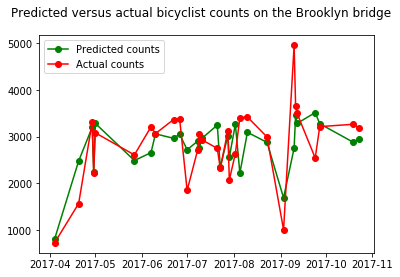

In [32]:
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

### Show scatter plot of actual versus predicted counts

<Figure size 432x288 with 0 Axes>

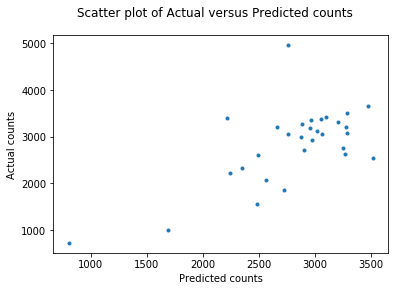

In [35]:
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts,y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

In [ ]:
#Initiate the model (using the default parameters)

In [37]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()

In [38]:
#fit the model with data

lg.fit(X_train, y_train)

C:\anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
y_pred = lg.predict(X_test)
y_pred

array([2171., 2590., 2590., 1903., 2807., 2301., 3893., 2465., 2687.,
       3174., 2467., 1892., 1892., 2860., 2840., 2283., 2301., 2301.,
       3492., 1805., 3893., 3191., 1876., 2021., 3264., 3264., 2810.,
       2565., 3169., 2751.])

In [43]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 257.44, 'Predicted')

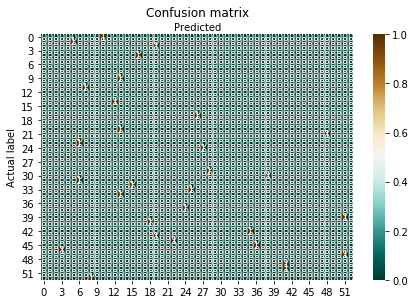

In [46]:
class_names = [0, 1] #name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create a heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='BrBG_r', fmt='g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted')